In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

I am using the [Lending Club dataset provided by Nathan George](https://www.kaggle.com/wordsforthewise/lending-club) that has all Lending Club loan features, which other datasets do not provide all features. I will work only with loans issued in 2018 to improve processing times.

To simplify the process, only certain columns / variables will be used in order to keep the project simple.

In [2]:
data = pd.read_csv("../../Data/loan_data_07_18.csv", low_memory=False)

In [3]:
df = data[['emp_length', 'loan_status', 'home_ownership', 'issue_d',
                          'earliest_cr_line', 'purpose', 'term', 'annual_inc', 'dti',
                          'loan_amnt', 'int_rate', 'pub_rec_bankruptcies', 'grade']].copy()

In [4]:
df

,emp_length,loan_status,home_ownership,issue_d,earliest_cr_line,purpose,term,annual_inc,dti,loan_amnt,int_rate,pub_rec_bankruptcies,grade
0,10+ years,Fully Paid,MORTGAGE,Dec-2015,Aug-2003,debt_consolidation,36 months,55000.0,5.91,3600.0,13.99,0.0,C
1,10+ years,Fully Paid,MORTGAGE,Dec-2015,Dec-1999,small_business,36 months,65000.0,16.06,24700.0,11.99,0.0,C
2,10+ years,Fully Paid,MORTGAGE,Dec-2015,Aug-2000,home_improvement,60 months,63000.0,10.78,20000.0,10.78,0.0,B
3,10+ years,Current,MORTGAGE,Dec-2015,Sep-2008,debt_consolidation,60 months,110000.0,17.06,35000.0,14.85,0.0,C
4,3 years,Fully Paid,MORTGAGE,Dec-2015,Jun-1998,major_purchase,60 months,104433.0,25.37,10400.0,22.45,0.0,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260696,9 years,Current,MORTGAGE,Oct-2016,Feb-1995,debt_consolidation,60 months,227000.0,12.75,40000.0,10.49,0.0,B
2260697,6 years,Charged Off,RENT,Oct-2016,Jul-1999,debt_consolidation,60 months,110000.0,18.30,24000.0,14.49,1.0,C
2260698,10+ years,Current,MORTGAGE,Oct-2016,Jun-1996,debt_consolidation,60 months,95000.0,23.36,14000.0,14.49,0.0,C
2260699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Data columns (total 13 columns):
 #   Column                Dtype  
---  ------                -----  
 0   emp_length            object 
 1   loan_status           object 
 2   home_ownership        object 
 3   issue_d               object 
 4   earliest_cr_line      object 
 5   purpose               object 
 6   term                  object 
 7   annual_inc            float64
 8   dti                   float64
 9   loan_amnt             float64
 10  int_rate              float64
 11  pub_rec_bankruptcies  float64
 12  grade                 object 
dtypes: float64(5), object(8)
memory usage: 224.2+ MB


### Fix dtypes

In [6]:
# Lets fix the dtypes

## Convert to datetime
df["earliest_cr_line"] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y')
df["issue_d"] = pd.to_datetime(df['issue_d'], format='%b-%Y')

### Missing data

In [7]:
df.isnull().sum()

emp_length              146940
loan_status                 33
home_ownership              33
issue_d                     33
earliest_cr_line            62
purpose                     33
term                        33
annual_inc                  37
dti                       1744
loan_amnt                   33
int_rate                    33
pub_rec_bankruptcies      1398
grade                       33
dtype: int64

PERSONAL DATA

Gives an idea to the lender about the borrower's general trustworthiness, credibility and personality.

- <code>'earliest_cr_line'</code> shows the first credit line on the customer credit report.
- <code>'issue_d'</code> shows when the loan was issued.
- <code>'pub_rec_bankruptcies'</code> shows the number of bankruptcies on file.

In [8]:
p_df = df[['pub_rec_bankruptcies', 'earliest_cr_line', 'issue_d']].copy()

In [9]:
p_df.isnull().sum()

pub_rec_bankruptcies    1398
earliest_cr_line          62
issue_d                   33
dtype: int64

In [10]:
## Fill in missing values by the most recurring value
p_df['pub_rec_bankruptcies'].fillna(p_df['pub_rec_bankruptcies']\
                              .value_counts().index[0], inplace=True)
p_df['earliest_cr_line'].fillna(p_df['earliest_cr_line']\
                              .value_counts().index[0], inplace=True)
p_df['issue_d'].fillna(p_df['issue_d']\
                              .value_counts().index[0], inplace=True)

In [11]:
# Create a new column with the credit history in months
p_df['credit_hist'] = (((p_df['issue_d'] - p_df['earliest_cr_line']).dt.days))/ 30
p_df['credit_hist'] = p_df['credit_hist'].astype(int)

p_df.head()

,pub_rec_bankruptcies,earliest_cr_line,issue_d,credit_hist
0,0.0,2003-08-01,2015-12-01,150
1,0.0,1999-12-01,2015-12-01,194
2,0.0,2000-08-01,2015-12-01,186
3,0.0,2008-09-01,2015-12-01,88
4,0.0,1998-06-01,2015-12-01,213


In [12]:
# Create a dummy column
p_df['bankrupt'] = p_df['pub_rec_bankruptcies']\
    .apply(lambda x: 1 if x >= 1 else 0)

p_df.head()

,pub_rec_bankruptcies,earliest_cr_line,issue_d,credit_hist,bankrupt
0,0.0,2003-08-01,2015-12-01,150,0
1,0.0,1999-12-01,2015-12-01,194,0
2,0.0,2000-08-01,2015-12-01,186,0
3,0.0,2008-09-01,2015-12-01,88,0
4,0.0,1998-06-01,2015-12-01,213,0


In [13]:
# drop the old features from the character_df
p_df.drop(['pub_rec_bankruptcies', 'earliest_cr_line', 'issue_d'], axis=1, inplace=True)
p_df.head()

,credit_hist,bankrupt
0,150,0
1,194,0
2,186,0
3,88,0
4,213,0


BORROWER'S CAPACITY TO PAY

Ability to repay the loan based on annual income and debt-to-income ratio.

- <code>'annual_inc'</code>
- <code>'dti'</code>

In [14]:
capacity_df = df[['annual_inc', 'dti']].copy()
capacity_df.head()

,annual_inc,dti
0,55000.0,5.91
1,65000.0,16.06
2,63000.0,10.78
3,110000.0,17.06
4,104433.0,25.37


In [15]:
capacity_df.isnull().sum()

annual_inc      37
dti           1744
dtype: int64

In [16]:
# fill missing values for annual income with the mean
capacity_df['annual_inc'] = capacity_df['annual_inc'].fillna(capacity_df['annual_inc'].mean())

# fill missing values for dti with the mean
capacity_df['dti'] = capacity_df['dti'].fillna(capacity_df['dti'].mean())

CONDITION OF THE LOAN

Conditions given to the borrower on the loan, such as loan amount, interest rate, and term.

- <code>'loan_amnt'</code>
- <code>'int_rate'</code>
- <code>'term'</code>

In [17]:
c_df = df[['loan_amnt', 'int_rate', 'term']].copy()

In [18]:
c_df.isnull().sum()

loan_amnt    33
int_rate     33
term         33
dtype: int64

In [19]:
# Fill missing values with mean
c_df['loan_amnt'] = c_df['loan_amnt'].fillna(c_df['loan_amnt'].mean())
c_df['int_rate'] = c_df['int_rate'].fillna(c_df['int_rate'].mean())

In [20]:
# Convert values of term to 0, 1 where 0 = 36 months and 1 = 60 months
c_df['term'] = c_df['term'].replace({' 36 months': 0,
                                                       ' 60 months': 1})

# convert term into an integer data type 
c_df['term'] = c_df['term'].fillna(c_df['term'].value_counts().index[0])

# Rename term column
c_df = c_df.rename(columns={'term': 'term_60'})

c_df.head()

,loan_amnt,int_rate,term_60
0,3600.0,13.99,0.0
1,24700.0,11.99,0.0
2,20000.0,10.78,1.0
3,35000.0,14.85,1.0
4,10400.0,22.45,1.0


COLLATERAL 

Borrowers provide an asset to secure a loan

- <code>'home_ownership'</code>

In [21]:
col_df = df[['home_ownership']].copy()
col_df.value_counts()

home_ownership
MORTGAGE          1111450
RENT               894929
OWN                253057
ANY                   996
OTHER                 182
NONE                   54
Name: count, dtype: int64

In [22]:
# create emp_length dummy data frame
home_ownership = pd.DataFrame(pd.get_dummies(col_df['home_ownership'], prefix='home_ownership', dtype=int))

# join the loan_amnt dummy dataframe to conditions_df
col_df = pd.concat([col_df, home_ownership], axis=1, sort=False)

# drop original emp_length feature
col_df.drop(['home_ownership'], axis=1, inplace=True)

col_df.head()

,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0


Loan Status

Current Status of the Loan. Target variable Y

- <code>'loan_status'</code>

In [23]:
loan_status_df = df[['loan_status']].copy()
loan_status_df.loan_status.value_counts()

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

In [24]:
loan_status_df['loan_status'] = loan_status_df['loan_status'].replace({'Fully Paid': 0, 'Current': 0, 'Charged Off': 1,
                                                                       'Late (31-120 days)': 1, 'In Grace Period': 1,
                                                                       'Late (16-30 days)':1,
                                                                       'Does not meet the credit policy. Status:Fully Paid': 0,
                                                                       'Does not meet the credit policy. Status:Charged Off': 1,
                                                                       'Default':1})
loan_status_df.loan_status.value_counts()

loan_status
0.0    1957056
1.0     303612
Name: count, dtype: int64

# Finalize working dataset

In [25]:
# Concatenate all the processed dataframes into a single one
working_data = pd.concat([p_df,
                          capacity_df,
                          c_df,
                          col_df,
                          loan_status_df,
                          df['grade']], axis=1, sort=False)
working_data.head()

,credit_hist,bankrupt,annual_inc,dti,loan_amnt,int_rate,term_60,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,loan_status,grade
0,150,0,55000.0,5.91,3600.0,13.99,0.0,0,1,0,0,0,0,0.0,C
1,194,0,65000.0,16.06,24700.0,11.99,0.0,0,1,0,0,0,0,0.0,C
2,186,0,63000.0,10.78,20000.0,10.78,1.0,0,1,0,0,0,0,0.0,B
3,88,0,110000.0,17.06,35000.0,14.85,1.0,0,1,0,0,0,0,0.0,C
4,213,0,104433.0,25.37,10400.0,22.45,1.0,0,1,0,0,0,0,0.0,F


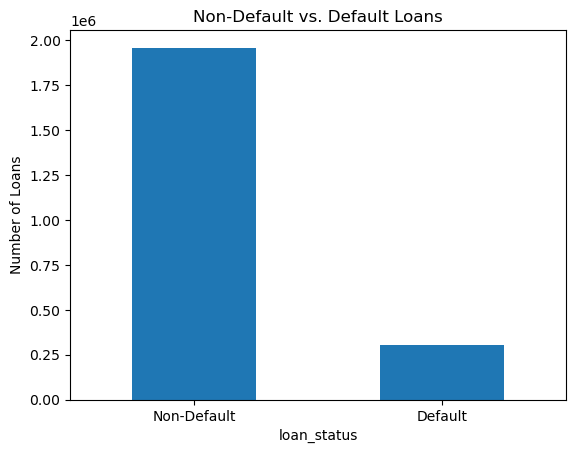

In [26]:
ax = working_data.loan_status.value_counts().plot(kind='bar')
labels = ['Non-Default', 'Default']
ax.set_xticklabels(labels, rotation='horizontal')
ax.set_ylabel('Number of Loans')
ax.set_title("Non-Default vs. Default Loans")
plt.show()

In [27]:
working_data = working_data.dropna()
working_data.to_parquet('../../data/working_data_pd.parquet')